In [1]:
from lavis_lib import *

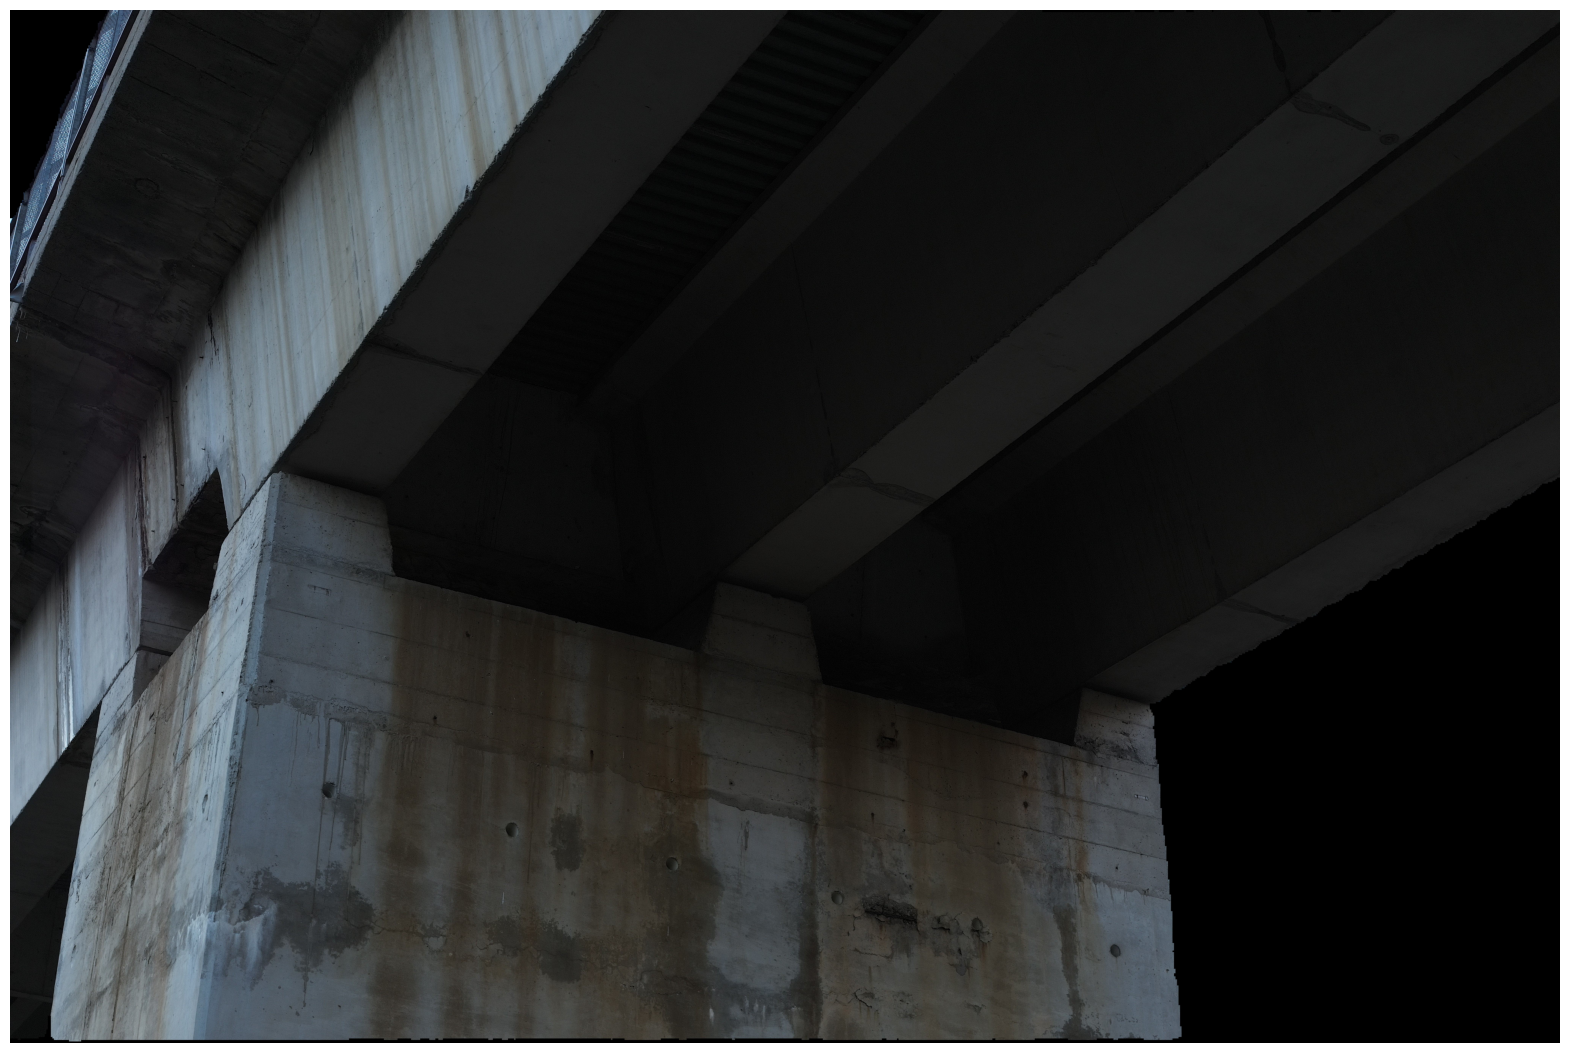

In [2]:
# a sample:

adapted_rootpath = os.path.join('..',ROOT_OUTFOLDERPATH)
# img_path = choice(get_all_images(adapted_rootpath))
img_path = '../../data/outputs/DJI_20221206151459_0231/DJI_20221206151459_0231.JPG'
raw_image = Image.open(img_path).convert("RGB")

plt.figure(figsize=(20,20))
plt.imshow(raw_image)
plt.axis('off')
plt.show()

In [3]:
from lavis.models import load_model_and_preprocess

model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
# generate caption
model.generate({"image": image})

['a stop sign on the side of a bridge']

In [5]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device)
# ask a random question.
question = "there are cracks in the bridge?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['yes']

In [6]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", model_type="base", is_eval=True, device=device)
caption = "a bridge with cracks"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
text_input = txt_processors["eval"](caption)
sample = {"image": image, "text_input": [text_input]}

features_multimodal = model.extract_features(sample)
print(features_multimodal.multimodal_embeds.shape)
# torch.Size([1, 12, 768]), use features_multimodal[:,0,:] for multimodal classification tasks

features_image = model.extract_features(sample, mode="image")
features_text = model.extract_features(sample, mode="text")
print(features_image.image_embeds.shape)
# torch.Size([1, 197, 768])
print(features_text.text_embeds.shape)
# torch.Size([1, 12, 768])

# low-dimensional projected features
print(features_image.image_embeds_proj.shape)
# torch.Size([1, 197, 256])
print(features_text.text_embeds_proj.shape)
# torch.Size([1, 12, 256])
similarity = features_image.image_embeds_proj[:,0,:] @ features_text.text_embeds_proj[:,0,:].t()
print(similarity)
# tensor([[0.2622]])

torch.Size([1, 6, 768])
torch.Size([1, 197, 768])
torch.Size([1, 6, 768])
torch.Size([1, 197, 256])
torch.Size([1, 6, 256])
tensor([[0.2770]], device='cuda:0')


In [7]:
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)


In [8]:
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np

dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

In [9]:
caption = 'a crack in the bridge'

In [10]:
img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)

In [11]:
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)

In [12]:
avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)


TypeError: Cannot interpret 'torch.float32' as a data type

In [ ]:
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_gradcam)

In [ ]:
num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(norm_img, gradcam, blur=True)
    ax[i].imshow(gradcam_image)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(word)